توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
# download data for training, validation and test and unxip them
%%capture
import os
if len(os.listdir()) <4 :
  !wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
  !wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
  !unzip ADEChallengeData2016.zip
  !unzip release_test.zip
  !pip install mmengine

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.functional as F

BORDER_MODE= [cv2.BORDER_WRAP, cv2.BORDER_REFLECT, cv2.BORDER_REPLICATE,  cv2.BORDER_CONSTANT]

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
dtype=torch.float32



Using cuda device


## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:
# define our functions
# function 1
def displacement(img):
  (h, w) = img.shape[:2]
  img = img.numpy()
  # two random shifting in range +-20 to +-100
  (x, y) = (random_number(20,100) , random_number(20,100))
  # Displacement can be achieved by shifting the image tensor
  M = np.float32([[1, 0, x], [0, 1, y]])
  img = cv2.warpAffine(img, M, (w, h), borderMode = BORDER_MODE[1])
  img =  torch.from_numpy(img)
  return img

# function 2
def rotation(img):
  # Rotate the image by +-15 to +-60 degrees
  angle =  random_number(15,60)
  # Get the image dimensions
  (h, w) = img.shape[:2]
  # Calculate the rotation matrix
  M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
  img = img.numpy()
  # Apply the rotation to the image
  img = cv2.warpAffine(img, M, (w, h), borderMode = BORDER_MODE[1])
  img =  torch.from_numpy(img)
  return img


# function 3
def scaling(img):
  (h, w) = img.shape[:2]
  # scale_type = 1 => zoom in , scale_type = 0 => zoom out
  scale_type = randint(0,1)
  scale = random.uniform(1.5, 3)
  if scale_type == 1 :
    img = img.permute(2,0,1)
    img = F.resize(img, [int(h*scale), int(w*scale)])
    crop = transforms.CenterCrop(min(w,h))
    img = crop(img)
    img = F.resize(img, [h, w])
  else:
    img = (img*255).numpy()
    img = cv2.copyMakeBorder(img, int(h*scale/8), int(h*scale/8), int(w*scale/8), int(w*scale/8),BORDER_MODE[1] )
    img =  torch.from_numpy(img)/255.0
    img = img.permute(2,0,1)
    img = F.resize(img, [h, w])

  img = img.permute(1,2,0)
  return img



# function 4
def Brightness(img):  ## for augmentation
  #  add/reduce random brightness to the image
  scale = 1 + random_number(10,90)/100
  img = img.permute(2,0,1)
  img = F.adjust_brightness(img, scale)
  img = img.permute(1,2,0)
  return img



# function 5
def bluring(img):# for augmentation
  # random scale of bluring
  scale = random.randrange(5, 15, 2)
  img = img.permute(2,0,1)
  img = F.gaussian_blur( img,scale,scale)
  img = img.permute(1,2,0)
  return img

# function 6
def gaussian_noise(img):#for augmentation
  # add random nois
  scale = random.uniform(0.2, 0.5)
  noise = torch.randn_like(img) * scale
  img = img + noise

  return img


# a function to get two bounday of numbers  return +- a number between them
def random_number(down,up ):
    if random.choice([True, False]):
        return random.randint(-up, -down)
    else:
        return random.randint(down, up)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0.5, 1.0, 'gaussian_noise')

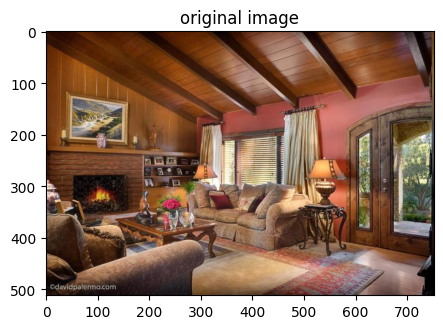

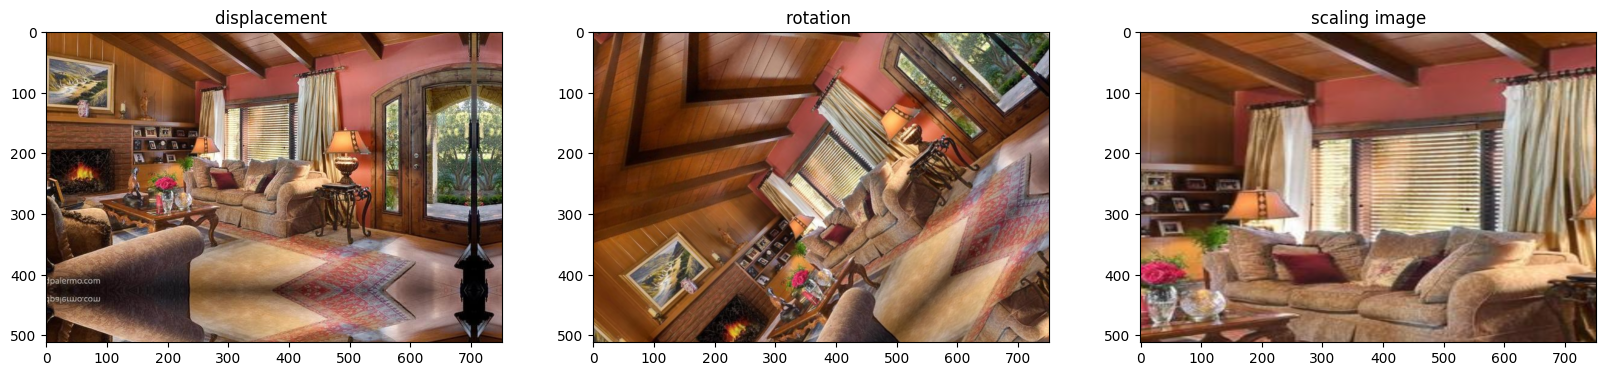

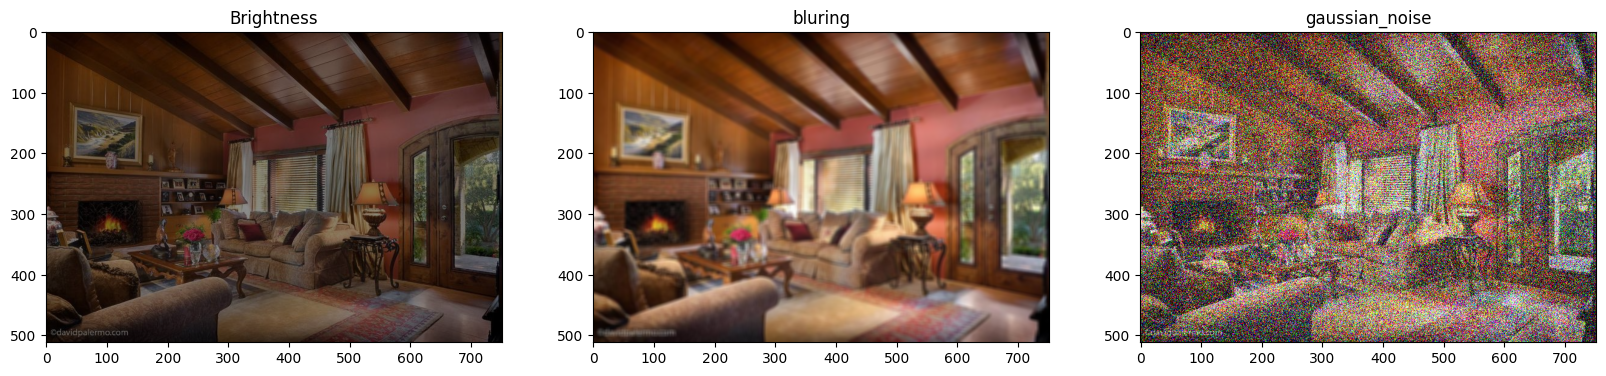

In [ ]:
#  load one image and do all function on it
image = cv2.imread('./ADEChallengeData2016/images/training/ADE_train_00000652.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image =  torch.from_numpy(image)/255.0


_,axes = plt.subplots( 1,1, figsize=(5, 5))
axes.imshow(image)
axes.set_title('original image')



_,axes = plt.subplots( 1,3, figsize=(20, 5))

axes[0].imshow(displacement(image))
axes[0].set_title('displacement ')

axes[1].imshow(rotation(image))
axes[1].set_title('rotation ')

axes[2].imshow(scaling(image))
axes[2].set_title('scaling image')

_,axes = plt.subplots( 1,3, figsize=(20, 5))
axes[0].imshow(Brightness(image))
axes[0].set_title('Brightness')

axes[1].imshow(bluring(image))
axes[1].set_title('bluring')

axes[2].imshow(gaussian_noise(image))
axes[2].set_title('gaussian_noise')



In [4]:
# define dataset
class CustomDataset(Dataset):
    def __init__(self, imgs_root, Type , transform=None):
        # self.img_dir = img_dir
        self.transform = transform
        self.Type  =Type
        self.path  = os.path.join(imgs_root,Type)

        self.imgs_name = os.listdir(self.path )

    def __len__(self):
        return len(self.imgs_name)

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.imgs_name[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image =  torch.from_numpy(image)/255.0

        trans_image = image

        # apply randomly 1 ,2 or 3 functions on the image
        functions = [ rotation , displacement ,scaling ]
        selected_functions= torch.tensor([0,0,0])
        n = randint(1,3)
        for func in random.sample(functions, n):
            trans_image = func(trans_image)
            index = functions.index(func)
            selected_functions[index] = 1

        # convert multi-hot vector to 8 entities one-hot vector
        code = int(''.join(map(str, selected_functions.tolist())), 2)
        label = torch.zeros(8)
        label[code] = 1

        return image.permute(2,0,1) , trans_image.permute(2,0,1) , label

In [5]:
# our images path
Root_train_valid = './ADEChallengeData2016/images/'
Root_test = './release_test/'
batch_size = 32
# define loaders
dataset_train = CustomDataset(Root_train_valid,'training')
dataset_test = CustomDataset(Root_test,'testing')
dataset_val = CustomDataset(Root_train_valid,'validation')

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)## To Do
test_loader= DataLoader(dataset_test, batch_size=8, shuffle=True)## To Do
val_loader = DataLoader(dataset_val, batch_size=8, shuffle=True)## To Do

['rotation', 'displacement', 'scaling']
['rotation', 'displacement', 'scaling']


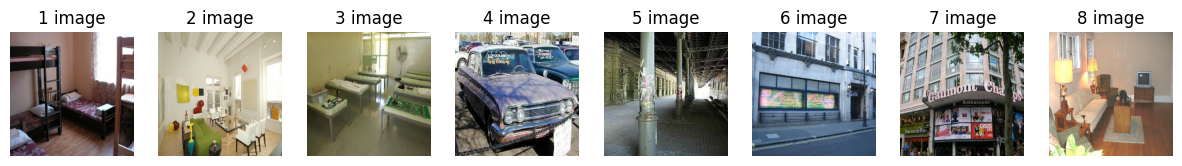

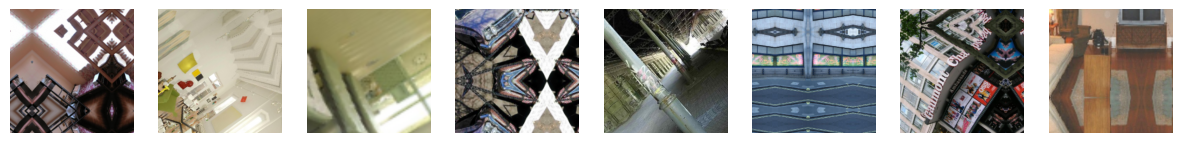

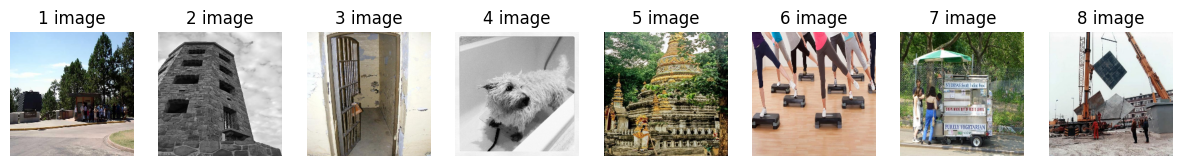

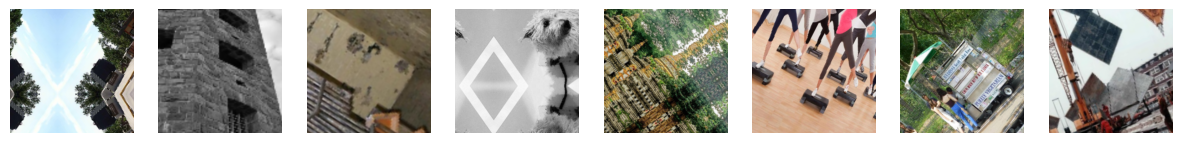

In [ ]:
# show some images and transposted
def show_images(num_images,org , trans):
    # TODO (implement show images function)
    #inputs dataset and number of images wants to show
    print(['rotation' , 'displacement' , 'scaling' ])
    #output plot images
    _,axes1 = plt.subplots( 1,num_images , figsize=(15, 5))
    _,axes2 = plt.subplots( 1,num_images , figsize=(15, 5))
    for i, ax in enumerate(axes1.flat):
        ax.imshow(org[i])
        ax.set_title(f'{i+1} image')
        ax.axis('off')

    for i, ax in enumerate(axes2.flat):
        ax.imshow(trans[i])
        ax.axis('off')

#############################################################################

for i, data in enumerate(train_loader, 0):
    train_org, train_trans , train_label= data
    break

for i, data in enumerate(test_loader, 0):
    test_org, test_trans , test_label= data
    break

show_images(8,train_org.permute(0,2,3,1) , train_trans.permute(0,2,3,1))
show_images(8,test_org.permute(0,2,3,1) , test_trans.permute(0,2,3,1))

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

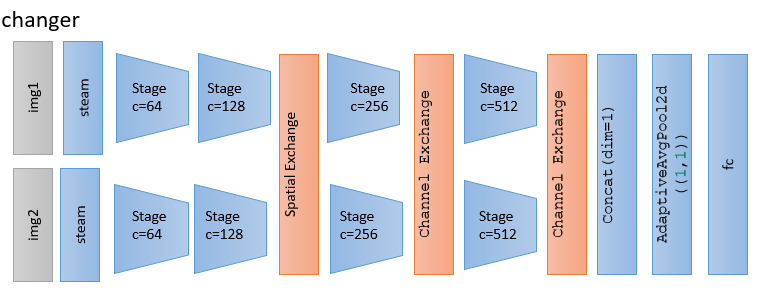

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


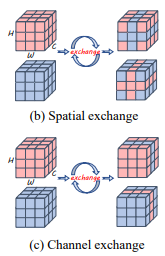

In [6]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

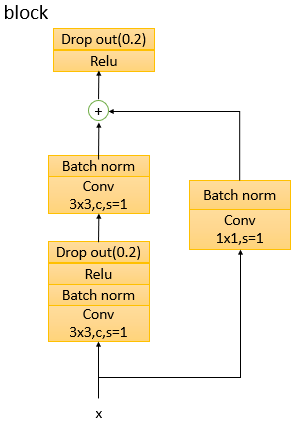

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





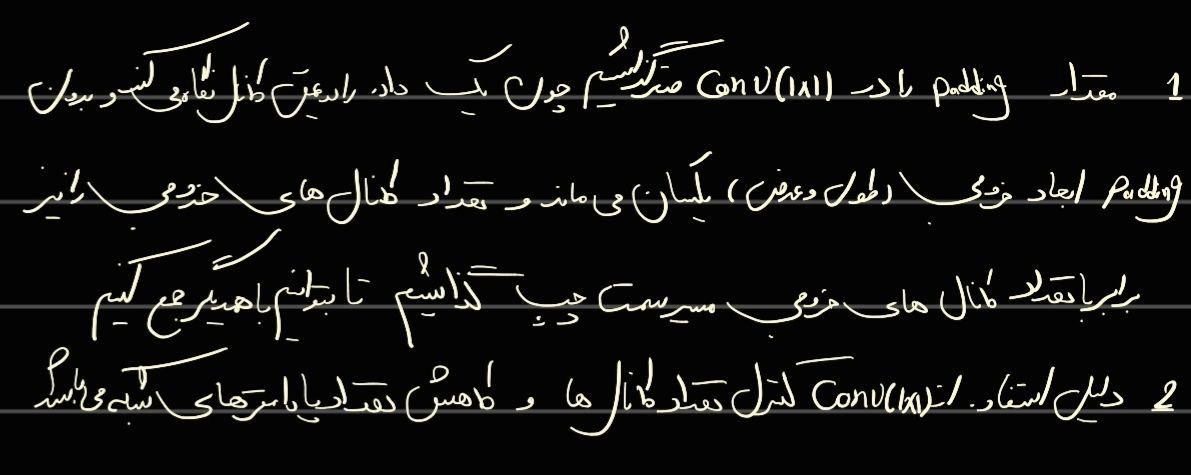

In [7]:
# define block class
class block(nn.Module):
  def __init__(self,input_channels, output_channels):
    super(block,self).__init__()
    self.left_stream = nn.Sequential(nn.Conv2d(input_channels , output_channels, kernel_size=(3,3), padding=1, stride=(1,1)) ,
                                      nn.BatchNorm2d(output_channels) ,
                                        nn.ReLU() , nn.Dropout(p=0.2) ,
                                        nn.Conv2d(output_channels, output_channels, kernel_size=(3,3), padding=1, stride=(1,1)) ,
                                         nn.BatchNorm2d(output_channels))
    self.right_stream = nn.Sequential(nn.Conv2d(input_channels , output_channels, kernel_size=(1,1), padding=0, stride=(1,1)) ,
                                       nn.BatchNorm2d(output_channels))
    self.Top = nn.Sequential(nn.ReLU() , nn.Dropout(p=0.2))

  def forward(self,x):
    s_r = self.right_stream(x)
    s_l = self.left_stream(x)
    out = self.Top(s_r  + s_l)
    return out

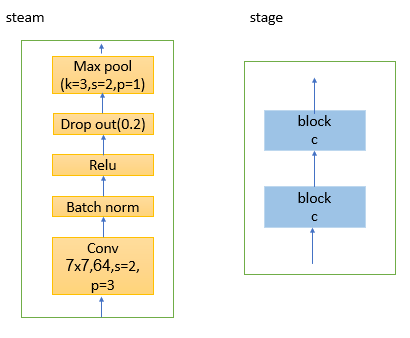

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [8]:
#define changer class
class changer(nn.Module):
  def __init__(self,block,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()
    self.Fully = nn.Sequential(nn.Linear(1024, 256), nn.Sigmoid(),nn.Linear(256, 8),nn.Softmax(dim=1))

    self.steam=nn.Sequential(nn.Conv2d(3 , 64, kernel_size=(7,7), padding=3, stride=(2,2)),
                              nn.BatchNorm2d(64), nn.ReLU(), nn.Dropout(p=0.2),
                              nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

    self.block = block
    self.SpatialExchange = SpatialExchange()
    self.ChannelExchange = ChannelExchange()
    self.avrage_pool = nn.AdaptiveAvgPool2d((1,1))

    self.stage1= self._make_stage(64,64)
    self.stage2= self._make_stage(64,128)
    self.stage3= self._make_stage(128,256)
    self.stage4= self._make_stage(256,512)

  def _make_stage(self,input_channels , output_channels):
    block_1 = self.block(input_channels,input_channels)
    block_2 = self.block(input_channels,output_channels)
    layers=[block_1,block_2]
    return nn.Sequential(*layers)



# pass the input
  def forward(self,x1,x2):
    out_su = self.steam(x1)
    out_sd = self.steam(x2)
    out_s1u = self.stage1(out_su)
    out_s1d = self.stage1(out_sd)
    out_s2u = self.stage2(out_s1u)
    out_s2d = self.stage2(out_s1d)
    out_sEXu , out_sEXd = self.SpatialExchange(out_s2u ,out_s2d)
    out_s3u = self.stage3(out_sEXu)
    out_s3d = self.stage3(out_sEXd)
    out_cEX1u ,out_cEX1d = self.ChannelExchange(out_s3u,out_s3d)
    out_s4u = self.stage4(out_cEX1u)
    out_s4d = self.stage4(out_cEX1d)
    out_cEX2u , out_cEX2d = self.ChannelExchange(out_s4u,out_s4d)
    out_con =torch.cat((out_cEX2u, out_cEX2d), dim=1)
    out_pool = self.avrage_pool(out_con)
    in_fc = torch.flatten(out_pool, start_dim=1)
    out = self.Fully(in_fc)

    return out

In [9]:
model = changer(block,SpatialExchange,ChannelExchange).to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

##Train & validation


In [13]:
# if checkpoint (pretained model) exists load the model parameters and optimizer state to our new model and optimizer
if 'checkpoint.pth' in os.listdir():
  checkpoint = torch.load('checkpoint.pth')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print('pre_train model is exist')
torch.cuda.empty_cache()

pre_train model is exist


In [ ]:
number_of_epoch = 10

for epoch in range(number_of_epoch):
  running_loss = 0
  total = 0
  correct = 0
  for raw_orgs, raw_trans ,raw_label in tqdm(train_loader, 0):
    torch.cuda.empty_cache()
    # raw_orgs , raw_trans , raw_label = data
    labels = raw_label.to(device)
    org = raw_orgs.to(device)
    trans = raw_trans.to(device)

    optimizer.zero_grad()

    # print(org.shape)
    # print(trans.shape)
    predict = model(org ,trans)
    loss = criterion(predict, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    total += labels.size(0)

    # loss_values.append(running_loss / total)
    # predicted = torch.where(predict > 0.5, torch.tensor(1.0), torch.tensor(0.0))
    _, max_indices = torch.max(predict.data, dim=1, keepdim=True)
    mask = torch.zeros_like(labels)
    predicted = mask.scatter_(1, max_indices, 1)

    correct += (torch.all(predicted == labels, dim=1)).sum().item()

  print(f'Training=>ecpoch:{epoch+1}, loss:{running_loss/ total} , accuracy:{100 * correct / total}')
  checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}
  torch.save(checkpoint, 'checkpoint.pth')
  running_loss = 0
  total = 0
  correct = 0
  for raw_orgs, raw_trans ,raw_label in tqdm(val_loader, 0):
    torch.cuda.empty_cache()
    labels = raw_label.to(device)
    org = raw_orgs.to(device)
    trans = raw_trans.to(device)
    predict = model(org ,trans)
    loss = criterion(predict, labels)
    running_loss += loss.item()
    total += labels.size(0)
    _, max_indices = torch.max(predict.data, dim=1, keepdim=True)
    mask = torch.zeros_like(labels)
    predicted = mask.scatter_(1, max_indices, 1)
    correct += (torch.all(predicted == labels, dim=1)).sum().item()
  print(f'Validation=>ecpoch:{epoch+1}, loss:{running_loss/ total} , accuracy:{100 * correct / total}')

print('Finished Training')
# I trained my model many times to achive this assuracy

100%|██████████| 632/632 [17:53<00:00,  1.70s/it]


Training=>ecpoch:1, loss:0.005252140951755317 , accuracy:66.70460168233548


100%|██████████| 250/250 [00:59<00:00,  4.21it/s]


Validation=>ecpoch:1, loss:0.024605358872562648 , accuracy:58.75


100%|██████████| 632/632 [17:52<00:00,  1.70s/it]


Training=>ecpoch:2, loss:0.005094443567609622 , accuracy:66.96190004948045


100%|██████████| 250/250 [00:59<00:00,  4.21it/s]


Validation=>ecpoch:2, loss:0.023970205128192902 , accuracy:63.2


100%|██████████| 632/632 [17:53<00:00,  1.70s/it]


Training=>ecpoch:3, loss:0.004984719663828921 , accuracy:68.52053438891637


100%|██████████| 250/250 [00:59<00:00,  4.23it/s]


Validation=>ecpoch:3, loss:0.02434126525372267 , accuracy:61.85


100%|██████████| 632/632 [17:50<00:00,  1.69s/it]


Training=>ecpoch:4, loss:0.004835817076262125 , accuracy:69.88124690747155


100%|██████████| 250/250 [00:59<00:00,  4.17it/s]


Validation=>ecpoch:4, loss:0.022170235726982356 , accuracy:64.6


100%|██████████| 632/632 [17:51<00:00,  1.69s/it]


Training=>ecpoch:5, loss:0.004801258515568431 , accuracy:69.29737753587332


100%|██████████| 250/250 [01:00<00:00,  4.15it/s]


Validation=>ecpoch:5, loss:0.022981069166213276 , accuracy:61.7


100%|██████████| 632/632 [17:51<00:00,  1.70s/it]


Training=>ecpoch:6, loss:0.0047279533907542545 , accuracy:69.74270163285502


100%|██████████| 250/250 [00:59<00:00,  4.20it/s]


Validation=>ecpoch:6, loss:0.022251657597720624 , accuracy:64.65


100%|██████████| 632/632 [17:50<00:00,  1.69s/it]


Training=>ecpoch:7, loss:0.004593613888296026 , accuracy:70.94507669470559


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


Validation=>ecpoch:7, loss:0.022875280402600767 , accuracy:62.95


100%|██████████| 632/632 [17:51<00:00,  1.70s/it]


Training=>ecpoch:8, loss:0.0045094123509247545 , accuracy:71.4497773379515


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


Validation=>ecpoch:8, loss:0.019451026346534492 , accuracy:69.25


100%|██████████| 632/632 [20:59<00:00,  1.99s/it]


Training=>ecpoch:9, loss:0.004328695456103368 , accuracy:73.26571004453241


100%|██████████| 250/250 [00:58<00:00,  4.24it/s]


Validation=>ecpoch:9, loss:0.02243090313859284 , accuracy:67.05


100%|██████████| 632/632 [21:06<00:00,  2.00s/it]


Training=>ecpoch:10, loss:0.00425401028984847 , accuracy:73.71598218703612


100%|██████████| 250/250 [01:00<00:00,  4.12it/s]

Validation=>ecpoch:10, loss:0.02042652072571218 , accuracy:68.15
Finished Training


#Test


In [ ]:
# save and download the model parameters and optimizer state
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}

torch.save(checkpoint, 'checkpoint.pth')
from google.colab import files
files.download('checkpoint.pth')

In [14]:
# evaluate the accuracy on test data
correct = 0
running_loss = 0
total = 0
for raw_orgs, raw_trans ,raw_label in tqdm(test_loader, 0):
    torch.cuda.empty_cache()
    labels = raw_label.to(device)
    org = raw_orgs.to(device)
    trans = raw_trans.to(device)
    predict = model(org ,trans)
    loss = criterion(predict, labels)
    running_loss += loss.item()
    total += labels.size(0)
    _, max_indices = torch.max(predict.data, dim=1, keepdim=True)
    mask = torch.zeros_like(labels)
    predicted = mask.scatter_(1, max_indices, 1)
    correct += (torch.all(predicted == labels, dim=1)).sum().item()
print(f'Test=>loss:{running_loss/ total} , accuracy:{100 * correct / total}')


100%|██████████| 419/419 [01:48<00:00,  3.85it/s]

Test=>loss:0.02166514469061696 , accuracy:67.33293556085918


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

In [ ]:
correct_one_change , total_one_change = 0 ,0
correct_two_change , total_two_change = 0 ,0
correct_three_change , total_three_change = 0 ,0


for raw_orgs, raw_trans ,raw_label in tqdm(val_loader, 0):
    torch.cuda.empty_cache()
    labels = raw_label.to(device)
    org = raw_orgs.to(device)
    trans = raw_trans.to(device)
    predict = model(org ,trans)
    _, max_indices = torch.max(predict.data, dim=1, keepdim=True)
    mask = torch.zeros_like(labels)
    predicted = mask.scatter_(1, max_indices, 1)

    labels = labels.int().tolist()
    predicted = predicted.int().tolist()


    for i , lab in enumerate(labels ,0):

      if lab in [[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,0,1,0,0,0]] :
        total_one_change += 1
        if lab == predicted[i]: correct_one_change+=1

      elif lab in [[0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0]] :
        total_two_change += 1
        if lab == predicted[i]: correct_two_change+=1

      elif lab in [[0,0,0,0,0,0,0,1]] :
        total_three_change += 1
        if lab == predicted[i]: correct_three_change+=1

print(f'\ntotal one change:{total_one_change} , number of correct:{correct_one_change}, accuracy:{correct_one_change/total_one_change*100}')
print(f'total two change:{total_two_change} , number of correct:{correct_two_change}, accuracy:{correct_two_change/total_two_change*100}')
print(f'total three change:{total_three_change} , number of correct:{correct_three_change}, accuracy:{correct_three_change/total_three_change*100}')

100%|██████████| 250/250 [01:02<00:00,  4.00it/s]


total one change:645 , number of correct:502, accuracy:77.82945736434108
total two change:704 , number of correct:337, accuracy:47.86931818181818
total three change:651 , number of correct:530, accuracy:81.41321044546851


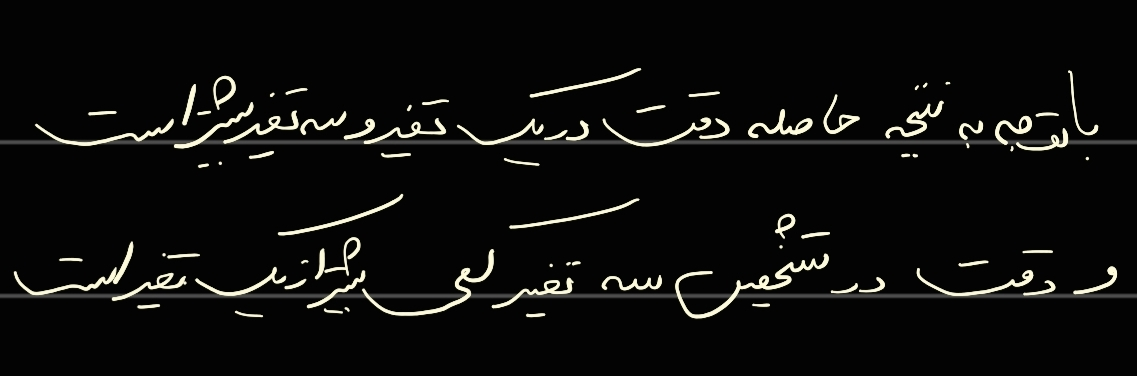